In [1]:
using DataFrames, CSV
using JuMP, Gurobi
using Plots, StatsPlots
using LinearAlgebra, Random, Distributions

## 1. Problem setup

We consider a graph with $n$ nodes, indexed by $i,j=1,\cdots,n$, and $K$ customers, indexed by $k=1,\cdots,K$. We have data on transportation costs $f_{ijk}$ and arc capacities $u_{ij}$. Each customer has a demand of $d_k$ from origin $O_k$ to destination $D_k$.

We want to solve the following multi-commodity flow problem:

$$\begin{align*}
    	 	\min &\ \sum_{(i,j)\in \mathcal{A}}\sum_{k\in \mathcal{K}} d_kf_{ijk}y_{ijk} \\
    		\text{s.t.}  &\  \sum_{j: (i,j)\in \mathcal{A}}y_{ijk} -\sum_{j: (j,i)\in \mathcal{A}}y_{jik} = \begin{cases}1 & i = O_k\\0 & i\neq O_k,D_k\\-1 & i = D_k \end{cases} \  \forall i\in \mathcal{N}, k\in \mathcal{K}  \\
    		&\ \sum_{k\in \mathcal{K}}d_ky_{ijk} \le u_{ij},  \   \forall (i,j)\in \mathcal{A}  \\
    		&\ y_{ijk}\geq0,\ \forall (i,j)\in \mathcal{A}, k\in \mathcal{K}
    \end{align*}$$
where:
$$\begin{aligned}
        y_{ijk}=\text{flow on arc $(i,j)$ for customer $k$}
    \end{aligned}$$

## 2. Preliminaries: a dynamic programming algorithm for the shortest path problem

We will need a shortest path algorithm to solve the pricing problem in our column generation algorithm. The shortest path problem is important in its own right, and so are dynamic programming algorithms for optimization problems. Therefore, we will dedicate this section to this algorithm. Let us first build a dedicated dataset and then develop the dynamic programming algorithm for the shortest path problem.

Reminder on the formulation:
$$\begin{align*}
	 	\min &\quad \sum_{(i,j)\in \mathcal{A}}c_{ij}y_{ij}\\
		\text{s.t.}  &\quad  \sum_{j: (i,j)\in \mathcal{A}}y_{ij} -\sum_{j: (j,i)\in \mathcal{A}}y_{ji} = \begin{cases}1 & i = O\\0 & i\neq O,D\\-1 & i = D \end{cases} \\
		&\quad y_{ij}\geq0,\ \forall (i,j)\in \mathcal{A}
    \end{align*}$$

In [2]:
numnodesSP = 100; #we will use "SP" to avoid confusion with the main multi-commodity flow problem
Random.seed!(1000)
square_size = 10; # km
nodesSP = rand(numnodesSP,2) * square_size;
distanceSP = [norm(nodesSP[i, :] .- nodesSP[j, :]) for i=1:numnodesSP,j=1:numnodesSP]
q = quantile(distanceSP[distanceSP.>0],.20);
arcstartnode=[];arcendnode=[];arcdistance=[];
for iSP in 1:numnodesSP, jSP in 1:numnodesSP
    if distanceSP[iSP,jSP]<=q && iSP!=jSP
        push!(arcstartnode,iSP,jSP)
        push!(arcendnode,jSP,iSP)
        push!(arcdistance,distanceSP[iSP,jSP],distanceSP[iSP,jSP])
    end
end
arcdataSP=hcat(arcstartnode,arcendnode,arcdistance)
numarcsSP = size(arcdataSP,1)

3960

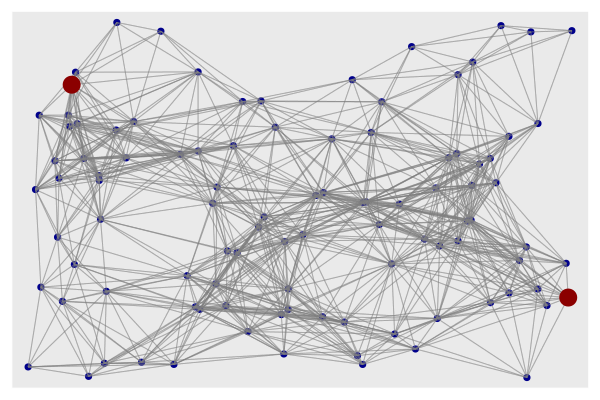

In [3]:
origin = 8;
destination = 19;
theme(:ggplot2)
plotSP = scatter(nodesSP[:, 1],nodesSP[:, 2],legend=false,ticks=false,color=:darkblue);
for arcSP = 1:numarcsSP
    plot!(plotSP, [nodesSP[Int(arcdataSP[arcSP,1]),1]; nodesSP[Int(arcdataSP[arcSP,2]),1]],[nodesSP[Int(arcdataSP[arcSP,1]),2]; nodesSP[Int(arcdataSP[arcSP,2]),2]],color=:gray,linealpha=0.2)
end
scatter!(plotSP,[nodesSP[origin,1]],[nodesSP[origin,2]],color=:darkred,markersize=10);
scatter!(plotSP,[nodesSP[destination,1]],[nodesSP[destination,2]],color=:darkred,markersize=10);
plotSP

In [4]:
function findshortestpath(arcdata,source,sink)
    
    arcstartnode = Int.(arcdata[:,1]);
    arcendnode = Int.(arcdata[:,2]);
    arcdistance = arcdata[:,3];
    numarcs=size(arcdata,1)
    numnodes = maximum(union(arcstartnode,arcendnode))
    
    currdistance = 999999999*ones(numnodes);
    currdistance[source] = 0

    prevnode, prevarc = zeros(numnodes), zeros(numnodes)
    
    for iteration in 1:numnodes #Max path length
        for arc in 1:numarcs
            n_start,n_end = arcstartnode[arc], arcendnode[arc]
            if currdistance[n_end] > currdistance[n_start] + arcdistance[arc] + 0.00001
                currdistance[n_end] = currdistance[n_start] + arcdistance[arc]
                prevnode[n_end] = n_start
                prevarc[n_end] = arc
            end
        end
    end
    
    shortestpatharcs = []
    node = sink
    while node != source
        pushfirst!(shortestpatharcs, Int(prevarc[node]))
        node = Int(prevnode[node])
    end

    return currdistance[sink], shortestpatharcs

end

findshortestpath (generic function with 1 method)

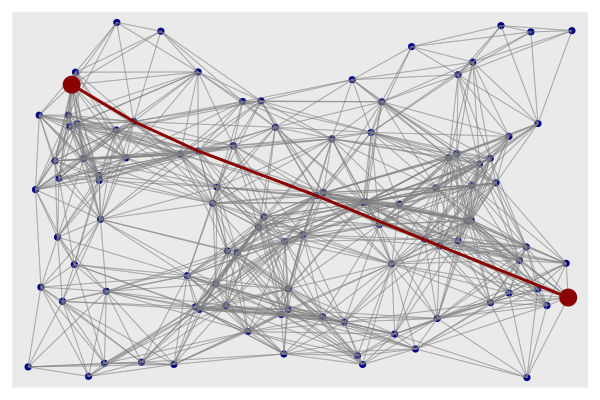

In [5]:
source = 8;
sink = 19;

shortestdist, shortestpatharcs = findshortestpath(arcdataSP,source,sink);
theme(:ggplot2)
plotSP = scatter(nodesSP[:, 1],nodesSP[:, 2],legend=false,ticks=false,color=:darkblue);
for arcSP = 1:numarcsSP
    plot!(plotSP, [nodesSP[Int(arcdataSP[arcSP,1]),1]; nodesSP[Int(arcdataSP[arcSP,2]),1]],[nodesSP[Int(arcdataSP[arcSP,1]),2]; nodesSP[Int(arcdataSP[arcSP,2]),2]],color=:gray,linealpha=0.2)
end
scatter!(plotSP,[nodesSP[origin,1]],[nodesSP[origin,2]],color=:darkred,markersize=10);
scatter!(plotSP,[nodesSP[destination,1]],[nodesSP[destination,2]],color=:darkred,markersize=10);
for arcSP = shortestpatharcs
    plot!(plotSP, [nodesSP[Int(arcdataSP[arcSP,1]),1]; nodesSP[Int(arcdataSP[arcSP,2]),1]],[nodesSP[Int(arcdataSP[arcSP,1]),2]; nodesSP[Int(arcdataSP[arcSP,2]),2]],color=:darkred,linewidth=3)
end

plotSP

## 2. Data setup

In [40]:
##Read arc data
#arcdata = CSV.read("MCF_arcs.csv", DataFrame);
#numarcs = size(arcdata)[1];
#arcstartnode, arcendnode = arcdata[!,2], arcdata[!,3];
#numnodes = maximum(union(arcstartnode, arcendnode))
#
##definition of arc capacities
#capacity = arcdata[!,4];
#
#arcdata

numnodes = 70; #we will use "SP" to avoid confusion with the main multi-commodity flow problem
Random.seed!(1000)
square_size = 10; # km
nodes = rand(numnodes,2) * square_size;
distance = [norm(nodes[i, :] .- nodes[j, :]) for i=1:numnodes,j=1:numnodes]
q = quantile(distance[distance.>0],.20);
arcstartnode=[];arcendnode=[];arcdistance=[];
for i in 1:numnodes, j in 1:numnodes
    if distance[i,j]<=q && i!=j
        push!(arcstartnode,i,j)
        push!(arcendnode,j,i)
        push!(arcdistance,distance[i,j],distance[i,j])
    end
end
arcdata=[arcstartnode arcendnode arcdistance]
numarcs=size(arcdata,1);

A_plus, A_minus = Dict(), Dict()
for n in 1:numnodes
    A_plus[n] = []
    A_minus[n] = []
end
for arc in 1:numarcs
    push!(A_plus[arcdata[arc,1]], arc)
    push!(A_minus[arcdata[arc,2]], arc)
end

cap_shape = 5;
cap_scale = 3;
capacity = rand(Gamma(cap_shape,cap_scale),numarcs);

1932-element Vector{Float64}:
 19.69808597683896
 32.22671700734212
 26.638842283883957
 14.883176777909853
 21.394727685879978
  4.7591804422361665
 13.75886946017575
 23.8056439601141
 25.4912824614374
 15.823290097244136
 27.132670965985106
 11.127110090546127
  6.592528558656486
  ⋮
  8.373415500173005
 17.637151643617546
 17.584853257151465
  7.969182397233766
 17.010990076571716
 13.423037868541503
 32.67875073095043
  6.786706861450842
 20.421727921720333
 14.210380204744418
 14.02472611206097
 14.992966295225653

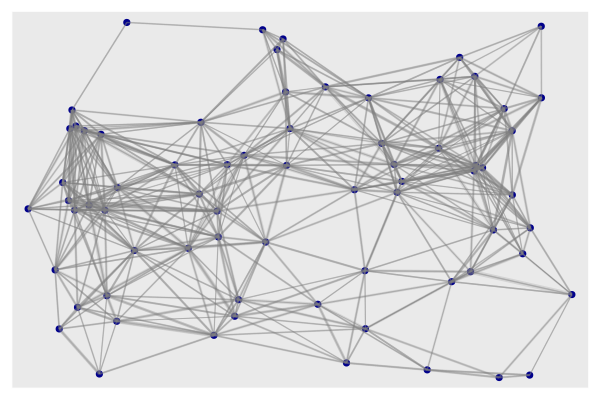

In [42]:
theme(:ggplot2)
plot = scatter(nodes[:, 1],nodes[:, 2],legend=false,ticks=false,color=:darkblue);
for arc = 1:numarcs
    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:gray,linealpha=0.2)
end
plot

In [26]:
##Read demand data
#demanddata = CSV.read("MCF_demand.csv", DataFrame)
#numcustomers = size(demanddata)[1]
#origin, destination, demand = demanddata[!,1], demanddata[!,2], demanddata[!,3];

##Read arc costs
#arccost = CSV.read("MCF_transport.csv", DataFrame)

numcustomers = 80;

origin = rand(1:numnodes,numcustomers);
destination = rand(1:numnodes,numcustomers);
for k = 1:numcustomers
    while origin[k]==destination[k]
        origin[k] = rand(1:numnodes);
        destination[k] = rand(1:numnodes);
    end
end

#definition of origin and destination nodes for each customer
nodesupply = zeros(numnodes, numcustomers)
for k in 1:numcustomers
    nodesupply[origin[k], k] = 1
    nodesupply[destination[k], k] = -1
end

demand_shape = 3;
demand_scale = 2;
demand = rand(Gamma(demand_shape,demand_scale),numcustomers);

f_shape = 8;
f_scale = .125;
arccost = (arcdistance*ones(1,numcustomers)) .* rand(Gamma(f_shape,f_scale),(numarcs,numcustomers));

## 3. Direct implementation

In [27]:
m_lp = Model(Gurobi.Optimizer)
set_optimizer_attribute(m_lp, "OutputFlag", 0)
@variable(m_lp, 0 <= x[k in 1:numcustomers, a in 1:numarcs] <= 1)
@objective(m_lp, Min, sum(sum(arccost[a,k] * demand[k] * x[k,a] for a in 1:numarcs) for k in 1:numcustomers) )
@constraint(m_lp, capacitycon_lp[a = 1:numarcs], sum(demand[k] * x[k, a] for k in 1:numcustomers) <= capacity[a])
@constraint(m_lp, flowbalance_lp[k in 1:numcustomers, i in 1:numnodes], sum(x[k, a] for a in A_plus[i]) - sum(x[k, a] for a in A_minus[i]) == nodesupply[i,k])

optimize!(m_lp)

println("LP = ", objective_value(m_lp))

#----------------------------------FULL IP FORMULATION----------------------------------#

m_ip = Model(Gurobi.Optimizer)
set_optimizer_attribute(m_ip, "OutputFlag", 0)
@variable(m_ip, x[k in 1:numcustomers, a in 1:numarcs], Bin)
@objective(m_ip, Min, sum(sum(arccost[a,k] * demand[k] * x[k,a] for a in 1:numarcs) for k in 1:numcustomers) )
@constraint(m_ip, capacitycon_lp[a = 1:numarcs], sum(demand[k] * x[k, a] for k in 1:numcustomers) <= capacity[a])
@constraint(m_ip, flowbalance_lp[k in 1:numcustomers, i in 1:numnodes], sum(x[k, a] for a in A_plus[i]) - sum(x[k, a] for a in A_minus[i]) == nodesupply[i,k])

status_ip = optimize!(m_ip)

println("IP = ", objective_value(m_ip))

Academic license - for non-commercial use only - expires 2023-07-21
LP = 1679.514420807839
Academic license - for non-commercial use only - expires 2023-07-21
IP = 1756.1964862068571


## 3. Column generation algorithm

### 3.1. Path-based formulation

We define a set of all possible paths for customer $k$ from origin $O_k$ to destination $D_k$ in $\mathcal{P}_k$. We introduce a binary indicator $\alpha_{ij}^p$ equal to 1 if path $p$ takes arc $(i,j)$ and 0 otherwise. We denote by $c_k^p$ the cost of path $p$ for customer $k$, as the sum of the cost contributions along all arcs comprising the path, i.e.: $c_k^p=\sum_{(i,j)\in\mathcal{A}}\alpha_{ij}^p\times f_{ijk}$.

We formulate the path-based multi-commodity flow problem as follows:
$$\begin{align*}
	 	\min &\ \sum_{k\in \mathcal{K}}\sum_{p\in \mathcal{P}_k} d_kc_k^pz_k^p \\
		\text{s.t.}  &\ \sum_{k\in \mathcal{K}}\sum_{p\in \mathcal{P}_k}d_k\alpha_{ij}^pz_k^p \le u_{ij},  \   \forall (i,j)\in \mathcal{A}  \\
		&\ \sum_{p\in \mathcal{P}_k}z_k^p=1,\ \forall k\in\mathcal{K}\\
		&\ z_k^p\geq0,\ \forall p\in \mathcal{P}_k, k\in \mathcal{K}
    \end{align*}$$

where:
$$\begin{aligned}
        z^k_p=\text{fraction of the demand from customer $k$ assigned to path $p$}
    \end{aligned}$$

### 3.2. Definition and intialization of paths

In [202]:
α = Dict()
pathcost = Dict()
pathSet = Dict()
for k in 1:numcustomers
    pathSet[k] = []
    pathcost[k] = []
end

In order to ensure feasibility, we define one "dummy" path from origin to destination for each customer, associated with an infinite capacity and a very large cost.

Note that the definition of $α_{ij}^p$ is a bit different from the mathematical formulation. In the mathematical notation, we define one value for each arc $(i,j)$ and for each path $p$ (across all customers). In the implementation, we define one value for each arc $a$ ($a$ stands for $(i,j)$), for each customer $k$, and for each path $p\in\mathcal{P}_k$ (for customer $k$). Obviously, the two representations are equivalent.

In [203]:
dummyarc = numarcs + 1
p = 1;
for k in 1:numcustomers
    push!(pathSet[k],1)
    for arc in 1:numarcs+1
        if arc == dummyarc
            α[k,arc,p] = 1
        else
            α[k,arc,p] = 0
        end
    end
    α[:,dummyarc,:] = 1;
    push!(pathcost[k], 1000000)
end

### 3.3. Full column generation algorithm

We are now ready to write the full column generation algorithm. We will iterate between the restricted master problem (RMP), which will solve the path-based multi-commodity flow formulation with a subset of paths, and the pricing problem (PP), which will generate new paths with negative reduced cost---or prove that none exists.

Let us start by building the restricted master problem.

In [204]:
rmp = Model(Gurobi.Optimizer)
set_optimizer_attribute(rmp, "OutputFlag", 0)
@variable(rmp, 0 <= y[k in 1:numcustomers, p in pathSet[k]])
@objective(rmp, Min, sum(sum(pathcost[k][p] * demand[k] * y[k,p] for p in pathSet[k]) for k in 1:numcustomers) );
@constraint(rmp, capacitycon[arc = 1:numarcs], sum(demand[k] * α[k,arc,p] * y[k,p] for k in 1:numcustomers, p in pathSet[k]) <= capacity[arc]);
@constraint(rmp, assignment[k in 1:numcustomers], sum(y[k,p] for p in pathSet[k]) == 1);


Academic license - for non-commercial use only - expires 2023-07-21


The subproblem is then written as:
$$\begin{align*}
    	 	\min &\quad d_k\cdot\sum_{(i,j)\in \mathcal{A}}(f_{ijk}+\pi_{ij})y_{ijk}&&-\lambda_k \\
    		\text{s.t.}  &\quad  \sum_{j: (i,j)\in \mathcal{A}}y_{ijk} -\sum_{j: (j,i)\in \mathcal{A}}y_{jik} = \begin{cases}1 & i = O_k\\0 & i\neq O_k,D_k\\-1 & i = D_k \end{cases} \  \forall i\in \mathcal{N}  \\
    		&\quad y_{ijk}\geq0,\ \forall (i,j)\in \mathcal{A}
        \end{align*}$$
        
where $\pi_{ij}$ and $\lambda_k$ denote the dual values of the arc capacity constraints and of the customer demand constraints, respectively.

In [199]:
global min_rc = -1

obj_all = [];
min_rc_all = [];
numpaths_all = [];

iteration = 0;

theme(:ggplot2)
plot = scatter(nodes[:, 1],nodes[:, 2],legend=false,ticks=false,color=:darkblue);
for arc = 1:numarcs
    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:gray,linealpha=0.2)
end

while (min_rc < -0.001)
    
    iteration = iteration + 1;
    plot_old = plot_new;
    
    optimize!(rmp)
    rmpobj = objective_value(rmp)
    push!(obj_all,rmpobj)
    if iteration ==3
        global rmpDEBUG = rmp;
    end

    π_dual = -dual.(capacitycon) #for a minimization problem with <= constraint, JuMP returns 
    λ_dual = dual.(assignment)

    min_rc_list = []
    addarcs = []
    
    numpaths = 0;
    for k in 1:numcustomers  
        arcredcosts = zeros(numarcs)
        for arc in 1:numarcs
            arcredcosts[arc] = arccost[arc,k]*demand[k] - demand[k]*π_dual[arc]
        end
        arcsPP = hcat(arcstartnode,arcendnode,arcredcosts)
        minreducedcost_k, shortestpatharcs = findshortestpath(arcsPP,origin[k],destination[k])
        fullminreducedcost = minreducedcost_k - λ_dual[k]
        push!(min_rc_list, fullminreducedcost)

        if fullminreducedcost < -0.001
            p = last(pathSet[k]) + 1
            push!(pathSet[k], p)
            
            for arc in shortestpatharcs
                α[k,arc,p] = 1
                if iteration==1
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:black);
                elseif iteration==2
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkred);
                elseif iteration==3
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkblue);
                elseif iteration==4
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkgreen);
                else
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:purple3);
                end
            end
            for arc in setdiff(1:numarcs+1, shortestpatharcs)
                α[k,arc,p] = 0
            end
            newpathcost = sum(arccost[arc,k] for arc in shortestpatharcs)
            push!(pathcost[k], newpathcost)
            
            global y[k,p] = @variable(rmp, lower_bound = 0) #, upper_bound = 1)
            set_name(y[k,p], string("y[",k,",",p,"]")) 
            set_objective_function(rmp, objective_function(rmp) + pathcost[k][p] * demand[k] * y[k,p])
            for arc in 1:numarcs
                set_normalized_coefficient(capacitycon[arc], y[k,p], α[k,arc,p] * demand[k])
            end
            set_normalized_coefficient(assignment[k], y[k,p], 1.0)
        end
        numpaths = numpaths + length(pathSet[k]);
    end
    push!(numpaths_all,numpaths)
    Plots.savefig(plot,string("19_network_",iteration,".png"))
    global min_rc = minimum(min_rc_list)
    push!(min_rc_all,min_rc)

end


In [205]:
global min_rc = -1

obj_all = [];
min_rc_all = [];
numpaths_all = [];

iteration = 0;

theme(:ggplot2)
plot = scatter(nodes[:, 1],nodes[:, 2],legend=false,ticks=false,color=:darkblue);
for arc = 1:numarcs
    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:gray,linealpha=0.2)
end

iteration = iteration + 1;
    plot_old = plot_new;
    
    optimize!(rmp)
    rmpobj = objective_value(rmp)
    push!(obj_all,rmpobj)
    if iteration ==3
        global rmpDEBUG = rmp;
    end

    π_dual = dual.(capacitycon)
    λ_dual = dual.(assignment)

    min_rc_list = []
    addarcs = []
    
    numpaths = 0;
    for k in 1:numcustomers  
        arcredcosts = zeros(numarcs)
        for arc in 1:numarcs
            arcredcosts[arc] = arccost[arc,k]*demand[k] - demand[k]*π_dual[arc]
        end
        arcsPP = hcat(arcstartnode,arcendnode,arcredcosts)
        minreducedcost_k, shortestpatharcs = findshortestpath(arcsPP,origin[k],destination[k])
        fullminreducedcost = minreducedcost_k - λ_dual[k]
        push!(min_rc_list, fullminreducedcost)

        if fullminreducedcost < -0.001
            p = last(pathSet[k]) + 1
            push!(pathSet[k], p)
            
            for arc in shortestpatharcs
                α[k,arc,p] = 1
                if iteration==1
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:black);
                elseif iteration==2
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkred);
                elseif iteration==3
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkblue);
                elseif iteration==4
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkgreen);
                else
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:purple3);
                end
            end
            for arc in setdiff(1:numarcs+1, shortestpatharcs)
                α[k,arc,p] = 0
            end
            newpathcost = sum(arccost[arc,k] for arc in shortestpatharcs)
            push!(pathcost[k], newpathcost)
            
            global y[k,p] = @variable(rmp, lower_bound = 0) #, upper_bound = 1)
            set_name(y[k,p], string("y[",k,",",p,"]")) 
            set_objective_function(rmp, objective_function(rmp) + pathcost[k][p] * demand[k] * y[k,p])
            for arc in 1:numarcs
                set_normalized_coefficient(capacitycon[arc], y[k,p], α[k,arc,p] * demand[k])
            end
            set_normalized_coefficient(assignment[k], y[k,p], 1.0)
        end
        numpaths = numpaths + length(pathSet[k]);
    end
    push!(numpaths_all,numpaths)
    Plots.savefig(plot,string("19_network_",iteration,".png"))
    global min_rc = minimum(min_rc_list)
    push!(min_rc_all,min_rc)

iteration = iteration + 1;
    plot_old = plot_new;
    
    optimize!(rmp)
    rmpobj = objective_value(rmp)
    push!(obj_all,rmpobj)
    if iteration ==3
        global rmpDEBUG = rmp;
    end

    π_dual = dual.(capacitycon)
    λ_dual = dual.(assignment)

    min_rc_list = []
    addarcs = []
    
    numpaths = 0;
    for k in 1:numcustomers  
        arcredcosts = zeros(numarcs)
        for arc in 1:numarcs
            arcredcosts[arc] = arccost[arc,k]*demand[k] - demand[k]*π_dual[arc]
        end
        arcsPP = hcat(arcstartnode,arcendnode,arcredcosts)
        minreducedcost_k, shortestpatharcs = findshortestpath(arcsPP,origin[k],destination[k])
        fullminreducedcost = minreducedcost_k - λ_dual[k]
        push!(min_rc_list, fullminreducedcost)

        if fullminreducedcost < -0.001
            p = last(pathSet[k]) + 1
            push!(pathSet[k], p)
            
            for arc in shortestpatharcs
                α[k,arc,p] = 1
                if iteration==1
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:black);
                elseif iteration==2
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkred);
                elseif iteration==3
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkblue);
                elseif iteration==4
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:darkgreen);
                else
                    plot!(plot, [nodes[Int(arcdata[arc,1]),1]; nodes[Int(arcdata[arc,2]),1]],[nodes[Int(arcdata[arc,1]),2]; nodes[Int(arcdata[arc,2]),2]],color=:purple3);
                end
            end
            for arc in setdiff(1:numarcs+1, shortestpatharcs)
                α[k,arc,p] = 0
            end
            newpathcost = sum(arccost[arc,k] for arc in shortestpatharcs)
            push!(pathcost[k], newpathcost)
            
            global y[k,p] = @variable(rmp, lower_bound = 0) #, upper_bound = 1)
            set_name(y[k,p], string("y[",k,",",p,"]")) 
            set_objective_function(rmp, objective_function(rmp) + pathcost[k][p] * demand[k] * y[k,p])
            for arc in 1:numarcs
                set_normalized_coefficient(capacitycon[arc], y[k,p], α[k,arc,p] * demand[k])
            end
            set_normalized_coefficient(assignment[k], y[k,p], 1.0)
        end
        numpaths = numpaths + length(pathSet[k]);
    end
    push!(numpaths_all,numpaths)
    Plots.savefig(plot,string("19_network_",iteration,".png"))
    global min_rc = minimum(min_rc_list)
    push!(min_rc_all,min_rc)



2-element Vector{Any}:
 -1.55124351929684e7
 -1.4101746731225353e7

In [127]:
obj_all
#min_rc_all
numpaths_all.-numcustomers

6-element Vector{Int64}:
  80
 112
 130
 135
 136
 136

In [107]:
println("LP = ", objective_value(m_lp))
println("CG = ", objective_value(rmp))

LP = 1679.514420807839
CG = 1679.5144208078389


In [206]:
dual_rpm = Model(Gurobi.Optimizer)
set_optimizer_attribute(dual_rpm, "OutputFlag", 0)
@variable(dual_rpm, 0 <= pi_dualvar[1:numarcs])
@variable(dual_rpm, lambda_dualvar[1:numcustomers])
@objective(dual_rpm, Max, -sum(capacity[arc]*pi_dualvar[arc] for arc in 1:numarcs)+sum(lambda_dualvar[k] for k in 1:numcustomers));
@constraint(dual_rpm, dualcon[k in 1:numcustomers, p in pathSet[k]], -demand[k]*sum(α[k,arc,p]*pi_dualvar[arc] for arc in 1:numarcs)+lambda_dualvar[k]<= demand[k]*pathcost[k][p]);



Academic license - for non-commercial use only - expires 2023-07-21


In [208]:
optimize!(rmp)
print(objective_value(rmp))
RC_y = reduced_cost.(y);

3.0132914252200622e7

In [209]:
optimize!(dual_rpm)
print(objective_value(dual_rpm))
pi_dualvar_opt = value.(pi_dualvar);
lambda_dualvar_opt = value.(lambda_dualvar);
dualRC_y = [];
for k in 1:numcustomers, p in pathSet[k]
    push!(dualRC_y,demand[k]*pathcost[k][p]+demand[k]*sum(α[k,arc,p]*pi_dualvar_opt[arc] for arc in 1:numarcs)-lambda_dualvar_opt[k]);
end

3.013291425220059e7

In [210]:
ind = 0;
for k in 1:numcustomers, p in pathSet[k]
    ind = ind + 1;
    if abs(RC_y[k,p]-dualRC_y[ind])>0.0001
        print([k p])
    end
end

In [211]:
    optimize!(rmp)
    rmpobj = objective_value(rmp)
    push!(obj_all,rmpobj)

    π_dual = dual.(capacitycon)
    λ_dual = dual.(assignment)

    min_rc_list = []
    addarcs = []
    
    numpaths = 0;
    minRC_k1 = zeros(numcustomers)
for k in 1:numcustomers
    
    arcredcosts = zeros(numarcs)
    for arc in 1:numarcs
        arcredcosts[arc] = arccost[arc,k]*demand[k] - demand[k]*π_dual[arc]
    end
    arcsPP = hcat(arcstartnode,arcendnode,arcredcosts)
    minreducedcost_k, shortestpatharcs = findshortestpath(arcsPP,origin[k],destination[k])
    fullminreducedcost = minreducedcost_k - λ_dual[k]
minRC_k1[k] = minreducedcost_k;
end

In [212]:
    optimize!(rmp)
    rmpobj = objective_value(rmp)
    push!(obj_all,rmpobj)

    π_dual = dual.(capacitycon)
    λ_dual = dual.(assignment)

    min_rc_list = []
    addarcs = []
    
    numpaths = 0;
    minRC_k2 = zeros(numcustomers)
for k in 1:numcustomers
    
    arcredcosts = zeros(numarcs)
    for arc in 1:numarcs
        arcredcosts[arc] = arccost[arc,k]*demand[k] + demand[k]*π_dual[arc]
    end
    arcsPP = hcat(arcstartnode,arcendnode,arcredcosts)
    minreducedcost_k, shortestpatharcs = findshortestpath(arcsPP,origin[k],destination[k])
    fullminreducedcost = minreducedcost_k - λ_dual[k]
minRC_k2[k] = minreducedcost_k;
end

LoadError: InterruptException:

In [217]:
minimum(π_dual)

-999998.2784028276